In [38]:
# %conda install pandas numpy scikit-learn matplotlib

import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

def get_dataset():
    data = pd.read_csv('data/cleveland.csv')
    X = data.drop('num', axis=1)
    y = data['num'].apply(lambda x: 1 if x > 0 else 0)
    
    X = X.replace('?', np.nan).astype(float)
    X = X.fillna(X.mean())
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X, y.values

def feature_selection(X, selected_features):
    return X[selected_features]

Ideal: 0.832
> folds=2, accuracy=0.832 (0.808,0.855)
> folds=3, accuracy=0.845 (0.832,0.871)
> folds=4, accuracy=0.825 (0.776,0.868)
> folds=5, accuracy=0.825 (0.717,0.885)
> folds=6, accuracy=0.835 (0.720,0.902)
> folds=7, accuracy=0.828 (0.744,0.909)
> folds=8, accuracy=0.832 (0.711,0.868)
> folds=9, accuracy=0.835 (0.697,0.941)
> folds=10, accuracy=0.825 (0.633,0.935)
> folds=11, accuracy=0.831 (0.630,0.963)
> folds=12, accuracy=0.835 (0.720,0.920)
> folds=13, accuracy=0.828 (0.696,0.958)
> folds=14, accuracy=0.828 (0.667,0.955)
> folds=15, accuracy=0.832 (0.600,0.950)
> folds=16, accuracy=0.835 (0.684,0.947)
> folds=17, accuracy=0.832 (0.667,1.000)
> folds=18, accuracy=0.832 (0.647,0.941)
> folds=19, accuracy=0.829 (0.688,0.938)
> folds=20, accuracy=0.835 (0.667,0.933)


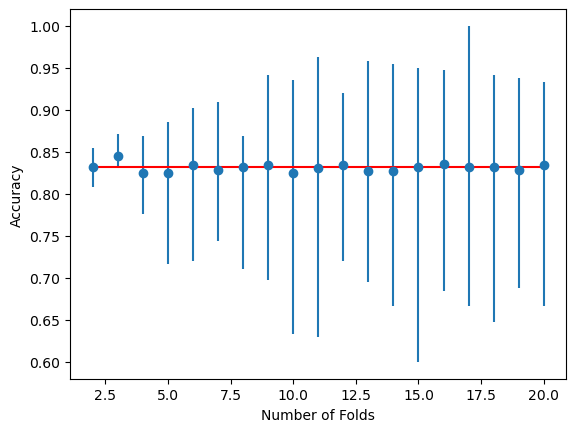

In [39]:
# Retrieve the model
def get_model():
    return LogisticRegression(max_iter=1000)

# def evaluate_model(cv):
#     X, y = get_dataset()
#     model = get_model()
#     scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#     return np.mean(scores), scores.min(), scores.max()

def evaluate_model(X, y, cv):
    model = get_model()
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return np.mean(scores), scores.min(), scores.max()

X, y = get_dataset()

ideal_features = ['cp', 'slope', 'chol', 'age', 'restecg', 'sex', 'fbs', 'exang']
X_selected = feature_selection(X, ideal_features)

# Evaluate using leave-one-out cross-validation
# ideal, _, _ = evaluate_model(X_selected, y, LeaveOneOut())
ideal, _, _ = evaluate_model(X, y, LeaveOneOut())
print('Ideal: %.3f' % ideal)

# Define folds to test, test from 2 to 20 folds
folds = range(2, 21)

# Perform k-fold cross-validation analysis
means, mins, maxs = [], [], []

for k in folds:
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    k_mean, k_min, k_max = evaluate_model(X, y, cv)
    print(f'> folds={k}, accuracy={k_mean:.3f} ({k_min:.3f},{k_max:.3f})')
    means.append(k_mean)
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)


# Line plot of k mean values with min/max error bars
pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')
pyplot.xlabel('Number of Folds')
pyplot.ylabel('Accuracy')
pyplot.show()

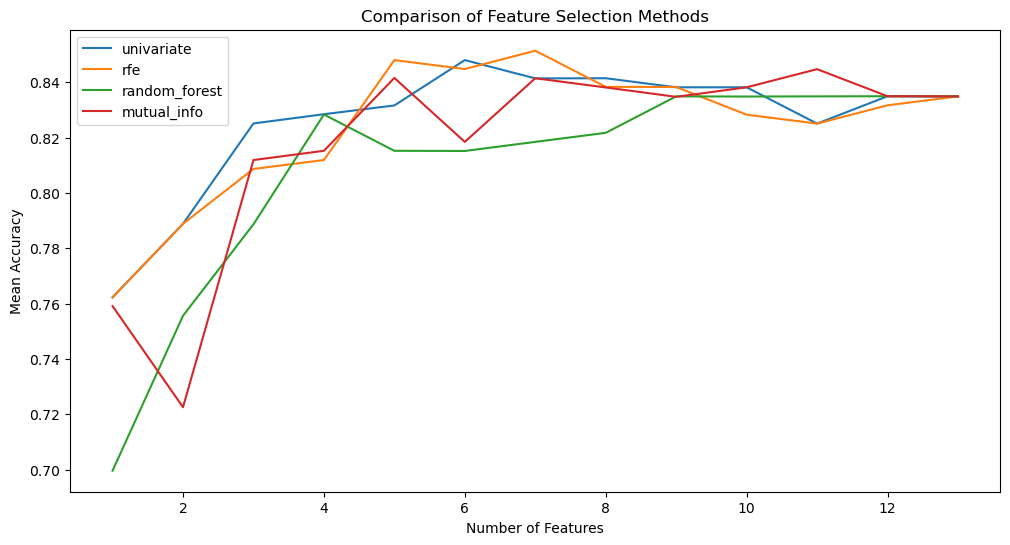

Best method: rfe
Best number of features: 7
Best features: sex, cp, thalach, exang, oldpeak, ca, thal


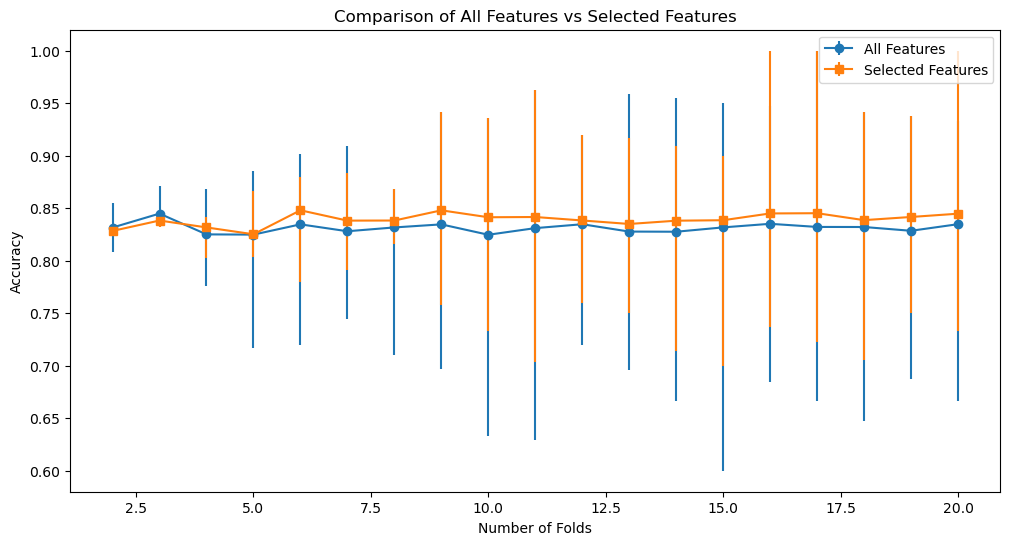


Final Results:
All Features - Mean Accuracy: 0.831
Selected Features - Mean Accuracy: 0.839


In [40]:
# TODO: Will need to perform feature selection

def perform_feature_selection(X, y, method='univariate', k=5):
    if method == 'univariate':
        selector = SelectKBest(f_classif, k=k)
        selector.fit(X, y)
        selected_features = X.columns[selector.get_support()].tolist()
    elif method == 'rfe':
        rfe = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=k)
        rfe.fit(X, y)
        selected_features = X.columns[rfe.support_].tolist()
    elif method == 'random_forest':
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1]
        selected_features = X.columns[indices[:k]].tolist()
    elif method == 'mutual_info':
        selector = SelectKBest(mutual_info_classif, k=k)
        selector.fit(X, y)
        selected_features = X.columns[selector.get_support()].tolist()
    else:
        raise ValueError("Invalid method. Choose 'univariate', 'rfe', 'random_forest', or 'mutual_info'.")
    
    return selected_features

def compare_feature_selection_methods(X, y, methods, k_range):
    results = {}
    for method in methods:
        method_results = []
        for k in k_range:
            selected_features = perform_feature_selection(X, y, method=method, k=k)
            X_selected = X[selected_features]
            cv = KFold(n_splits=5, shuffle=True, random_state=42)
            mean_score, _, _ = evaluate_model(X_selected, y, cv)
            method_results.append(mean_score)
        results[method] = method_results
    return results

# Main analysis
X, y = get_dataset()

# Compare different feature selection methods
methods = ['univariate', 'rfe', 'random_forest', 'mutual_info']
k_range = range(1, len(X.columns) + 1)
results = compare_feature_selection_methods(X, y, methods, k_range)

# Plot results
plt.figure(figsize=(12, 6))
for method in methods:
    plt.plot(k_range, results[method], label=method)
plt.xlabel('Number of Features')
plt.ylabel('Mean Accuracy')
plt.title('Comparison of Feature Selection Methods')
plt.legend()
plt.show()

# Select the best method and number of features
best_method = max(results, key=lambda x: max(results[x]))
best_k = k_range[np.argmax(results[best_method])]
print(f"Best method: {best_method}")
print(f"Best number of features: {best_k}")

# Get the best features
best_features = perform_feature_selection(X, y, method=best_method, k=best_k)
print(f"Best features: {', '.join(best_features)}")

# Compare performance: all features vs. selected features
X_selected = X[best_features]
folds = range(2, 21)
means_all, mins_all, maxs_all = [], [], []
means_selected, mins_selected, maxs_selected = [], [], []

for k in folds:
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    
    # All features
    k_mean, k_min, k_max = evaluate_model(X, y, cv)
    means_all.append(k_mean)
    mins_all.append(k_mean - k_min)
    maxs_all.append(k_max - k_mean)
    
    # Selected features
    k_mean, k_min, k_max = evaluate_model(X_selected, y, cv)
    means_selected.append(k_mean)
    mins_selected.append(k_mean - k_min)
    maxs_selected.append(k_max - k_mean)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.errorbar(folds, means_all, yerr=[mins_all, maxs_all], fmt='o-', label='All Features')
plt.errorbar(folds, means_selected, yerr=[mins_selected, maxs_selected], fmt='s-', label='Selected Features')
plt.xlabel('Number of Folds')
plt.ylabel('Accuracy')
plt.title('Comparison of All Features vs Selected Features')
plt.legend()
plt.show()

# Print final results
print("\nFinal Results:")
print(f"All Features - Mean Accuracy: {np.mean(means_all):.3f}")
print(f"Selected Features - Mean Accuracy: {np.mean(means_selected):.3f}")

Ideal: 0.840
> folds=2, accuracy=0.740 (0.700,0.780)
> folds=3, accuracy=0.749 (0.697,0.824)
> folds=4, accuracy=0.800 (0.680,0.920)
> folds=5, accuracy=0.800 (0.600,0.950)
> folds=6, accuracy=0.820 (0.688,0.941)
> folds=7, accuracy=0.799 (0.571,1.000)
> folds=8, accuracy=0.811 (0.385,0.923)
> folds=9, accuracy=0.829 (0.636,1.000)
> folds=10, accuracy=0.850 (0.600,1.000)
> folds=11, accuracy=0.829 (0.667,1.000)
> folds=12, accuracy=0.785 (0.250,1.000)
> folds=13, accuracy=0.839 (0.571,1.000)
> folds=14, accuracy=0.807 (0.429,1.000)
> folds=15, accuracy=0.821 (0.571,1.000)
> folds=16, accuracy=0.827 (0.500,1.000)
> folds=17, accuracy=0.816 (0.600,1.000)
> folds=18, accuracy=0.831 (0.600,1.000)
> folds=19, accuracy=0.826 (0.600,1.000)
> folds=20, accuracy=0.830 (0.600,1.000)
> folds=21, accuracy=0.814 (0.500,1.000)
> folds=22, accuracy=0.820 (0.500,1.000)
> folds=23, accuracy=0.802 (0.250,1.000)
> folds=24, accuracy=0.804 (0.250,1.000)
> folds=25, accuracy=0.810 (0.250,1.000)
> folds=26,

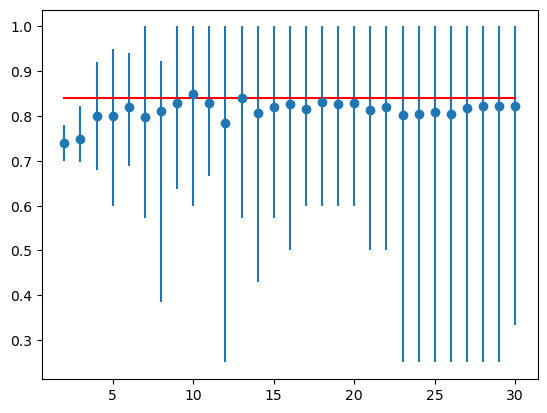

In [41]:
# Example from https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

# sensitivity analysis of k in k-fold cross-validation
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

# create the dataset
def get_dataset(n_samples=100):
	X, y = make_classification(n_samples=n_samples, n_features=20, n_informative=15, n_redundant=5, random_state=1)
	return X, y

# retrieve the model to be evaluate
def get_model():
	model = LogisticRegression()
	return model

# evaluate the model using a given test condition
def evaluate_model(cv):
	# get the dataset
	X, y = get_dataset()
	# get the model
	model = get_model()
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# return scores
	return mean(scores), scores.min(), scores.max()

# calculate the ideal test condition
ideal, _, _ = evaluate_model(LeaveOneOut())
print('Ideal: %.3f' % ideal)
# define folds to test
folds = range(2,31)
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()
# evaluate each k value
for k in folds:
	# define the test condition
	cv = KFold(n_splits=k, shuffle=True, random_state=1)
	# evaluate k value
	k_mean, k_min, k_max = evaluate_model(cv)
	# report performance
	print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
	# store mean accuracy
	means.append(k_mean)
	# store min and max relative to the mean
	mins.append(k_mean - k_min)
	maxs.append(k_max - k_mean)
# line plot of k mean values with min/max error bars
pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
pyplot.show()

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.metrics import balanced_accuracy_score
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import LeaveOneOut

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, message="A single label was found in 'y_true' and 'y_pred'.")
warnings.filterwarnings("ignore", category=UserWarning, message="y_pred contains classes not in y_true")
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


In [52]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    X = data.drop('num', axis=1)
    y = data['num'].apply(lambda x: 1 if x > 0 else 0)  # Convert to binary classification
    
    X = X.replace('?', np.nan).astype(float)
    X = X.fillna(X.mean())
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X, y

In [53]:
def select_features(X, y, k, method='univariate'):
    if method == 'univariate':
        selector = SelectKBest(f_classif, k=k)
    elif method == 'mutual_info':
        selector = SelectKBest(mutual_info_classif, k=k)
    elif method == 'rfe':
        selector = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=k)
    elif method == 'random_forest':
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1]
        return X.columns[indices[:k]].tolist()
    else:
        raise ValueError("Invalid method. Choose 'univariate', 'mutual_info', 'rfe', or 'random_forest'.")
    
    selector.fit(X, y)
    return X.columns[selector.get_support()].tolist()

In [54]:
def get_model():
    return LogisticRegression(max_iter=1000)

def evaluate_model(X, y, cv):
    model = get_model()
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
    return np.mean(scores), scores.min(), scores.max()

def safe_balanced_accuracy(y_true, y_pred):
    try:
        return balanced_accuracy_score(y_true, y_pred)
    except ValueError:
        return float(y_true[0] == y_pred[0])

def evaluate_model_loocv(X, y):
    loo = LeaveOneOut()
    model = get_model()
    scores = []
    n_samples = X.shape[0]
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        score = safe_balanced_accuracy(y_test, y_pred)
        scores.append(score)
        
        if (len(scores) % 50 == 0) or (len(scores) == n_samples):
            print(f"Processed {len(scores)}/{n_samples} samples. Current average score: {np.mean(scores):.3f}")
    
    return np.mean(scores)


In [55]:
def evaluate_model_with_feature_selection(X, y, k, method='univariate', n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        selected_features = select_features(X_train, y_train, k, method)
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        model = get_model()
        model.fit(X_train_selected, y_train)
        
        y_pred = model.predict(X_test_selected)
        
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
    
    return precision_scores, recall_scores, f1_scores, selected_features

In [56]:
def compare_feature_selection_methods(X, y, methods, k_range):
    results = {}
    for method in methods:
        method_results = []
        for k in k_range:
            _, _, f1_scores, _ = evaluate_model_with_feature_selection(X, y, k, method)
            method_results.append(np.mean(f1_scores))
        results[method] = method_results
    return results


Processed 50/303 samples. Current average score: 0.880
Processed 100/303 samples. Current average score: 0.840
Processed 150/303 samples. Current average score: 0.853
Processed 200/303 samples. Current average score: 0.840
Processed 250/303 samples. Current average score: 0.844
Processed 300/303 samples. Current average score: 0.833
Processed 303/303 samples. Current average score: 0.832
Ideal (Leave-One-Out): 0.832


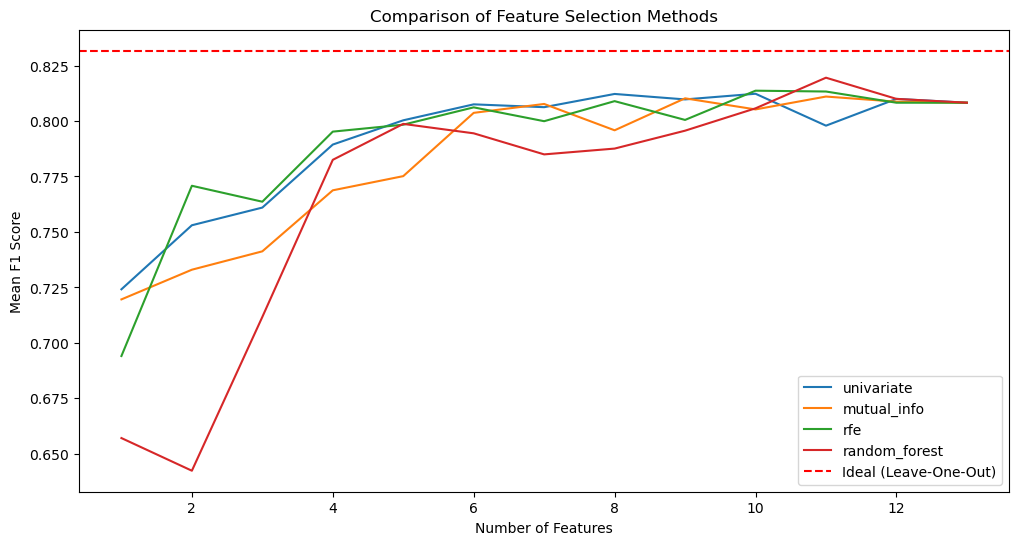

Best method: random_forest
Best number of features: 11

Final Results:
Precision scores: [0.85, 0.9230769230769231, 0.6666666666666666, 0.75, 0.9166666666666666, 0.7857142857142857, 0.7777777777777778, 1.0, 0.9090909090909091, 0.8333333333333334]
Recall scores: [0.9444444444444444, 0.8571428571428571, 0.7692307692307693, 0.9230769230769231, 0.7333333333333333, 1.0, 0.5833333333333334, 0.7222222222222222, 0.8333333333333334, 0.7692307692307693]
F1 scores: [0.8947368421052632, 0.8888888888888888, 0.7142857142857143, 0.8275862068965517, 0.8148148148148148, 0.88, 0.6666666666666666, 0.8387096774193549, 0.8695652173913043, 0.8]
Mean F1 score: 0.820
Best features: ['thalach', 'cp', 'thal', 'ca', 'oldpeak', 'age', 'chol', 'trestbps', 'slope', 'exang', 'sex']


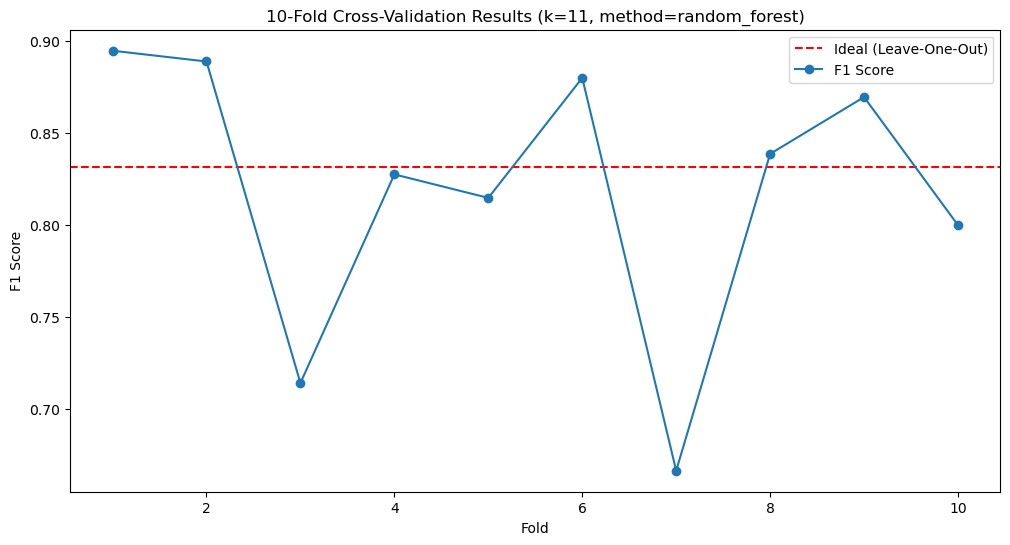

In [57]:
def main():
    X, y = load_and_preprocess_data('data/cleveland.csv')
    
    # Calculate the ideal test condition using Leave-One-Out
    ideal = evaluate_model_loocv(X, y)
    print('Ideal (Leave-One-Out): %.3f' % ideal)
    
    # Compare different feature selection methods
    methods = ['univariate', 'mutual_info', 'rfe', 'random_forest']
    k_range = range(1, len(X.columns) + 1)
    results = compare_feature_selection_methods(X, y, methods, k_range)
    
    # Plot comparison of feature selection methods
    plt.figure(figsize=(12, 6))
    for method in methods:
        plt.plot(k_range, results[method], label=method)
    plt.axhline(y=ideal, color='r', linestyle='--', label='Ideal (Leave-One-Out)')
    plt.xlabel('Number of Features')
    plt.ylabel('Mean F1 Score')
    plt.title('Comparison of Feature Selection Methods')
    plt.legend()
    plt.show()
    
    # Find best method and k
    best_method = max(results, key=lambda x: max(results[x]))
    best_k = k_range[np.argmax(results[best_method])]
    print(f"Best method: {best_method}")
    print(f"Best number of features: {best_k}")
    
    # Evaluate with best method and k
    precision_scores, recall_scores, f1_scores, best_features = evaluate_model_with_feature_selection(X, y, best_k, best_method)
    
    print("\nFinal Results:")
    print(f"Precision scores: {precision_scores}")
    print(f"Recall scores: {recall_scores}")
    print(f"F1 scores: {f1_scores}")
    print(f"Mean F1 score: {np.mean(f1_scores):.3f}")
    print(f"Best features: {best_features}")
    
    # Plot k-fold cross-validation results
    folds = range(1, 11)
    plt.figure(figsize=(12, 6))
    plt.errorbar(folds, f1_scores, fmt='o-', label='F1 Score')
    plt.axhline(y=ideal, color='r', linestyle='--', label='Ideal (Leave-One-Out)')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.title(f'10-Fold Cross-Validation Results (k={best_k}, method={best_method})')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

In [49]:
def predict_challenge_dataset(challenge_file, original_file, best_k, best_method):
    X_original, y_original = load_and_preprocess_data(original_file)
    X_challenge, _ = load_and_preprocess_data(challenge_file)
    
    best_features = select_features(X_original, y_original, best_k, best_method)
    X_original_selected = X_original[best_features]
    X_challenge_selected = X_challenge[best_features]
    
    model = get_model()
    model.fit(X_original_selected, y_original)
    
    y_pred = model.predict(X_challenge_selected)
    return y_pred
